In [111]:
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.cluster as cls
import sklearn.metrics as met
import sklearn.neighbors as nb

import utils

In [112]:
data_path = "./data"

## Load road graph
# road_graph: nx.DiGraph
# with open(f"{data_path}/road_graph_nsl_sc.pickle", mode="rb") as file:
#     road_graph = pickle.load(file)
road_graph = ox.load_graphml(f"{data_path}/road_graph_ox_sim_nsl_sc.xml")
road_graph = ox.project_graph(road_graph, to_crs=utils.EPSG_32650)

## Load camera info
cameras_dict: dict
with open(f"{data_path}/road_graph_ox_sim_cameras.pickle", mode="rb") as file:
    cameras_dict = pickle.load(file)

Silhouette Score: 0.4959369053847586
Region weights:  [1719555, 1104920, 930636, 1138239]


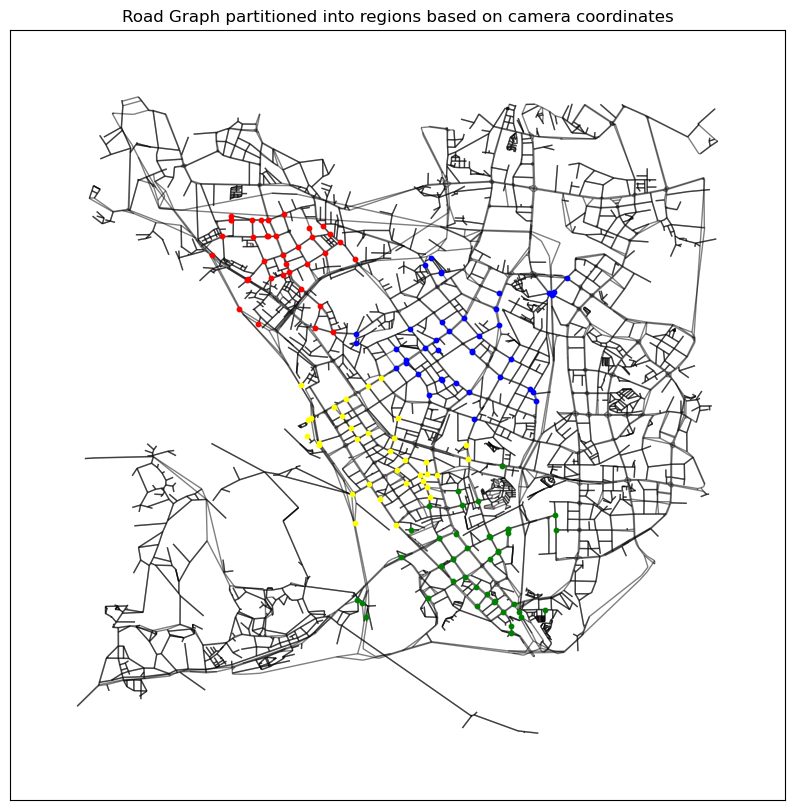

In [113]:
# Parameters
seed = 666
number_of_regions = 4
colors = ["red", "green", "blue", "yellow"]

# nodes = [{"node_id": node[0], "x": node[1]["pos"][0], "y": node[1]["pos"][1]} for node in road_graph.nodes(data=True)]
nodes = [{"node_id": node, "x": road_graph.nodes[node]["x"], "y": road_graph.nodes[node]["y"]} for node in
         road_graph.nodes()]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

cameras = list(cameras_dict.values())
camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])
camera_node_ids = {camera["node_id"] for camera in cameras}

# Clustering
k_means_cameras = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means_cameras.fit_predict(camera_coordinates)
print(f"Silhouette Score: {met.silhouette_score(camera_coordinates, regions, random_state=seed)}")

# Record distribution
region_weights = [0 for _ in set(regions)]
for region, camera in zip(regions, cameras):
    region_weights[region] += camera["records"]
print("Region weights: ", region_weights)

# Matching nodes to cluster centroids
kd_tree = nb.KDTree(k_means_cameras.cluster_centers_)
indices = kd_tree.query(node_coordinates, k=1, return_distance=False)

node_sets = [set() for _ in range(indices.max() + 1)]
for node, index in zip(nodes, indices):
    index = index[0]
    if node["node_id"] in camera_node_ids:
        node_sets[index].add(node["node_id"])
    # node_sets[index].add(node["node_id"])

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# pos = nx.get_node_attributes(road_graph, "pos")
pos = {node: (road_graph.nodes[node]["x"], road_graph.nodes[node]["y"]) for node in road_graph.nodes()}

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax
)

for index, node_set in enumerate(node_sets):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=10,
        nodelist=node_set,
        ax=ax
    )

ax.set_title("Road Graph partitioned into regions based on camera coordinates")

plt.show()